In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import os

import sys
sys.path.append("../utility_functions/")
from objectProperties import ObjectProperties
from readExtrapolatedSpectra import ReadExtrapolatedSpectra

sys.path.append("../../Filter_Curves/")
from readBands import ReadBands

In [2]:
#Use the latex font when plotting. 
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [3]:
#Load the properties of the BHDs
op = ObjectProperties()

In [4]:
#Load the bands.
bands = ReadBands()
for bname in bands.bandnames:
    print(bname, bands.bp[bname].barlam(), bands.bp[bname].fwhm(), bands.bp[bname].rectwidth())

R_SPECIAL 6501.229535920617 Angstrom 1159.881393925198 Angstrom 1624.9974574790472 Angstrom
I_BESS 7925.773360798338 Angstrom 1080.5202412457434 Angstrom 1433.1539789444323 Angstrom
v_HIGH 5531.691038305597 Angstrom 850.6231300284223 Angstrom 1195.0838113345558 Angstrom


In [5]:
#Load the spectra for each BHD, extended using the best-fit SED.
specs = ReadExtrapolatedSpectra()

Wavelength range for object W0019-1046 limited because of sky template
Spec-range: 3001.5 Angstrom - 5423.93 Angstrom
Sky-range: 3199.4 Angstrom - 6724.06 Angstrom
Wavelength range for object W0204-0506 limited because of sky template
Spec-range: 3786.2 Angstrom - 6672.70 Angstrom
Sky-range: 3789.3 Angstrom - 6682.76 Angstrom
Warning, 2 of 3161 bins contained negative fluxes; they have been set to zero.
Wavelength range for object W0831+0140 limited because of sky template
Spec-range: 3786.2 Angstrom - 6672.45 Angstrom
Sky-range: 3789.3 Angstrom - 6682.76 Angstrom
Warning, 2 of 3161 bins contained negative fluxes; they have been set to zero.


In [6]:
op.filters

{'W0019-1046': ['R_SPECIAL'],
 'W0204-0506': ['R_SPECIAL'],
 'W0220+0137': ['R_SPECIAL'],
 'W0831+0140': ['R_SPECIAL'],
 'W0116-0505': ['R_SPECIAL', 'I_BESS', 'v_HIGH']}

In [7]:
for wid in specs.wids:
    print(specs.specs.sp[wid].lam_rest.unit, specs.specs.sp[wid].flam.unit)
    print(specs.specs.sp[wid].instrument, specs.specs.sp[wid].zspec)

Angstrom erg / (Angstrom s cm2)
DBSP 1.641
Angstrom erg / (Angstrom s cm2)
SDSS 3.173
Angstrom erg / (Angstrom s cm2)
GMOS 2.099307
Angstrom erg / (Angstrom s cm2)
SDSS 3.122
Angstrom erg / (Angstrom s cm2)
GMOS 3.888


In [8]:
bands.bp['R_SPECIAL'].barlam().value

6501.229535920617

In [9]:
latex_band_name = {
    "v_HIGH"    : r'$v_{\rm High}$',
    "R_SPECIAL" : r'$R_{\rm Special}$',
    "I_BESS"    : r'$I_{\rm Bessel}$',
}

Text(0.5, 0.05, 'Rest-frame Wavelength $(\\rm \\AA)$')

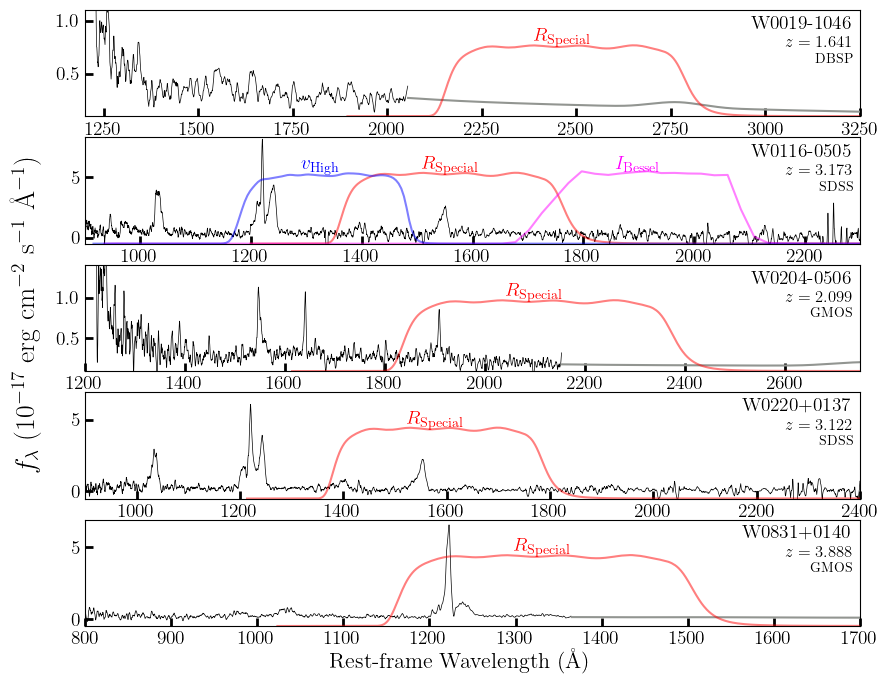

In [10]:
ymin = {"W0019-1046": 0.1, "W0116-0505": -0.5, "W0204-0506": 0.1, "W0220+0137": -0.5, "W0831+0140": -0.5}
ymax = {"W0019-1046": 1.1, "W0116-0505":  8.3, "W0204-0506": 1.4, "W0220+0137":  6.9, "W0831+0140": None}

xmin = {"W0019-1046": 1200., "W0116-0505":  900., "W0204-0506": 1200., "W0220+0137": 900., "W0831+0140":  800.}
xmax = {"W0019-1046": 3250., "W0116-0505": 2300., "W0204-0506": 2750., "W0220+0137": 2400., "W0831+0140": 1700.}

fig, axs = plt.subplots(5, figsize=(10,8))

wids_use = ["W0019-1046", "W0116-0505", "W0204-0506", "W0220+0137", "W0831+0140"]

for i, wid in enumerate(wids_use):

    #fig, ax = plt.subplots(1, figsize=(10,3))
    ax = axs[i]
    ax.tick_params(direction='in', labelsize=14, width=2, length=6)

    #First, plot the spectrum using smoothing from a savgol filter. 
    flam_use = savgol_filter(specs.specs.sp[wid].flam, 21, 3)
    ax.plot(specs.specs.sp[wid].lam_rest, flam_use*1e17, color='black', lw=0.5)

    #Now, plot the extension based on the best-fit SED model.
    cond = specs.lam_obs[wid] > np.max(specs.specs.sp[wid].lam_obs)
    ax.plot(specs.lam_rest[wid][cond], specs.flam[wid][cond]*1e17, color='xkcd:grey')

    #Plot the filters. 
    trans = matplotlib.transforms.blended_transform_factory(ax.transData, ax.transAxes)
    for filt in op.filters[wid]:
            if filt=='v_HIGH':
                norm = 1./100.
                color = "blue"
            else:
                norm = 1.
                if filt=='R_SPECIAL':
                     color='red'
                else:
                     color='magenta'
            ax.plot(bands.bp[filt].model.points[0]/(1+op.z[wid]), bands.bp[filt].model.lookup_table*norm*0.7, color=color, transform=trans, alpha=0.5)
            ax.text(bands.bp[filt].barlam().value/(1+op.z[wid]), 0.7, latex_band_name[filt], transform=trans, ha='center', fontsize=14, color=color)

    ax.set_ylim([ymin[wid],ymax[wid]])
    ax.set_xlim([xmin[wid],xmax[wid]])

    ax.text(0.99, 0.82, wid, ha='right', fontsize=14, transform=ax.transAxes)
    ax.text(0.99, 0.65, r'$z={:.3f}$'.format(op.z[wid]), ha='right', fontsize=12, transform=ax.transAxes)
    ax.text(0.99, 0.50, specs.specs.sp[wid].instrument, ha='right', fontsize=10, transform=ax.transAxes)

    #plt.show()
    #fig.savefig('{}_spec.png'.format(wid), dpi=200, bbox_inches='tight')

fig.supylabel(r'$f_{\lambda}~(10^{-17}~\rm erg~\rm cm^{-2}~\rm s^{-1}~\rm \AA^{-1})$', fontsize=20, x=0.05)
fig.supxlabel(r'Rest-frame Wavelength $(\rm \AA)$', fontsize=16, y=0.05)

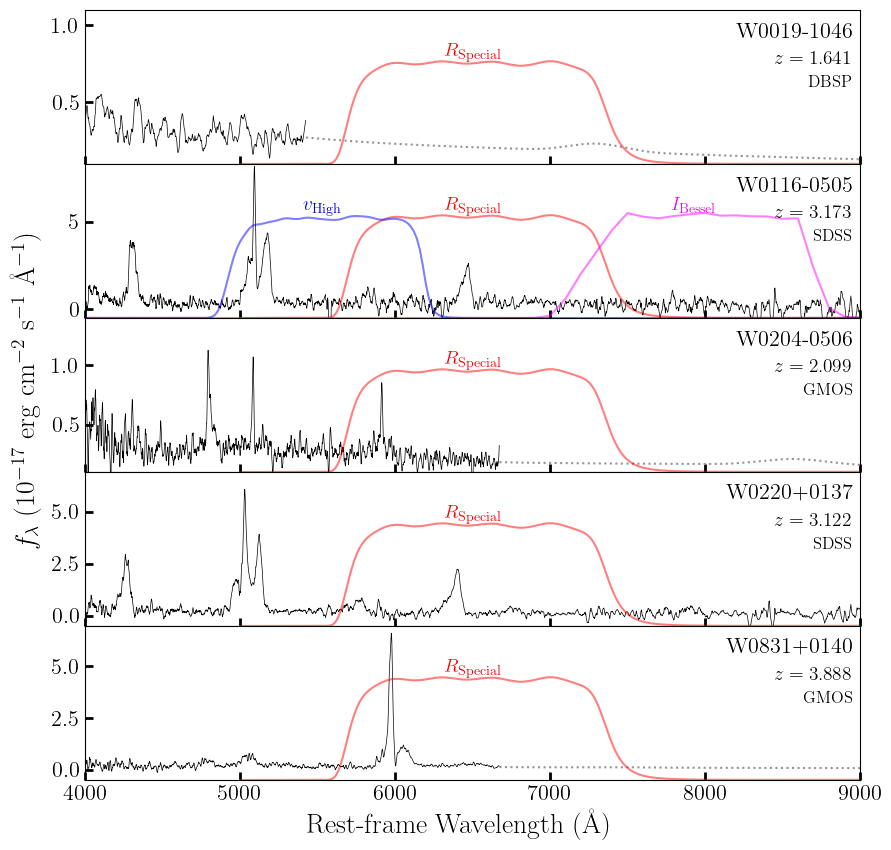

In [11]:
ymin = {"W0019-1046": 0.1, "W0116-0505": -0.5, "W0204-0506": 0.1, "W0220+0137": -0.5, "W0831+0140": -0.5}
ymax = {"W0019-1046": 1.1, "W0116-0505":  8.3, "W0204-0506": 1.4, "W0220+0137":  6.9, "W0831+0140": None}

fig, axs = plt.subplots(5, figsize=(10,10), sharex=True)

wids_use = ["W0019-1046", "W0116-0505", "W0204-0506", "W0220+0137", "W0831+0140"]

for i, wid in enumerate(wids_use):

    #fig, ax = plt.subplots(1, figsize=(10,3))
    ax = axs[i]
    ax.tick_params(direction='in', labelsize=16, width=2, length=6)

    #First, plot the spectrum using smoothing from a savgol filter. 
    flam_use = savgol_filter(specs.specs.sp[wid].flam, 21, 3)
    ax.plot(specs.specs.sp[wid].lam_obs, flam_use*1e17, color='black', lw=0.5)

    #Now, plot the extension based on the best-fit SED model.
    cond = specs.lam_obs[wid] > np.max(specs.specs.sp[wid].lam_obs)
    ax.plot(specs.lam_obs[wid][cond], specs.flam[wid][cond]*1e17, color='xkcd:grey', ls='dotted')

    #Plot the filters. 
    trans = matplotlib.transforms.blended_transform_factory(ax.transData, ax.transAxes)
    for filt in op.filters[wid]:
            if filt=='v_HIGH':
                norm = 1./100.
                color = "blue"
            else:
                norm = 1.
                if filt=='R_SPECIAL':
                     color='red'
                else:
                     color='magenta'
            ax.plot(bands.bp[filt].model.points[0], bands.bp[filt].model.lookup_table*norm*0.7, color=color, transform=trans, alpha=0.5)
            ax.text(bands.bp[filt].barlam().value, 0.7, latex_band_name[filt], transform=trans, ha='center', fontsize=14, color=color)

    ax.set_ylim([ymin[wid],ymax[wid]])
    ax.set_xlim([4000., 9000.])

    ax.text(0.99, 0.82, wid, ha='right', fontsize=16, transform=ax.transAxes)
    ax.text(0.99, 0.65, r'$z={:.3f}$'.format(op.z[wid]), ha='right', fontsize=14, transform=ax.transAxes)
    ax.text(0.99, 0.50, specs.specs.sp[wid].instrument, ha='right', fontsize=12, transform=ax.transAxes)

    #plt.show()
    #fig.savefig('{}_spec.png'.format(wid), dpi=200, bbox_inches='tight')

plt.subplots_adjust(wspace=0.0,hspace=0.0)
fig.supylabel(r'$f_{\lambda}~(10^{-17}~\rm erg~\rm cm^{-2}~\rm s^{-1}~\rm \AA^{-1})$', fontsize=20, x=0.05)
fig.supxlabel(r'Rest-frame Wavelength $(\rm \AA)$', fontsize=20, y=0.05)

plt.show()

fig.savefig("specs_all.png", dpi=200, bbox_inches='tight')

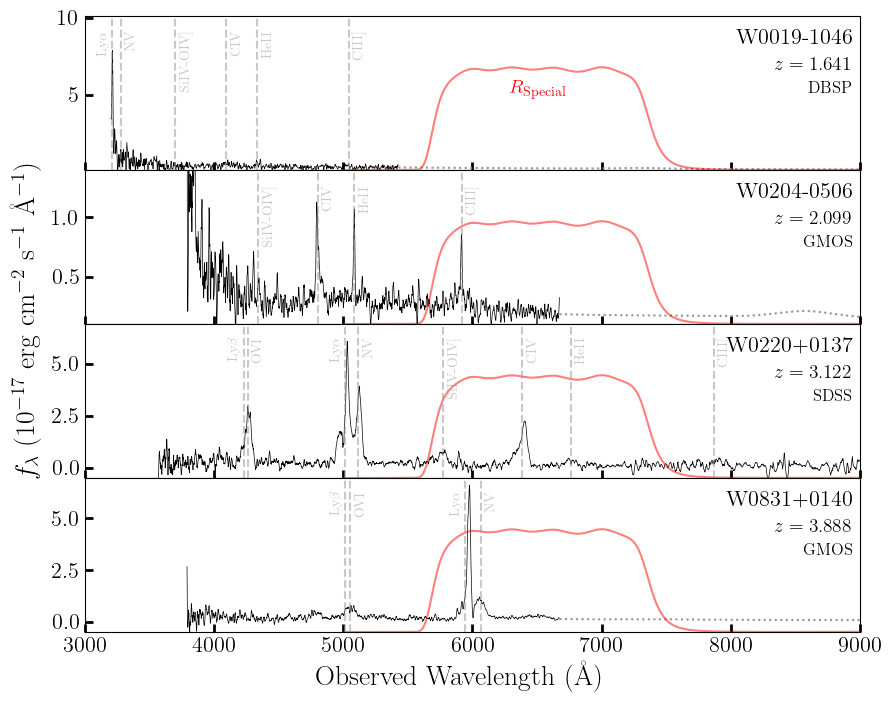

In [48]:
ymin = {"W0019-1046": 0.1, "W0116-0505": -0.5, "W0204-0506": 0.1, "W0220+0137": -0.5, "W0831+0140": -0.5}
#ymax = {"W0019-1046": 1.1, "W0116-0505":  8.3, "W0204-0506": 1.4, "W0220+0137":  6.9, "W0831+0140": None}
ymax = {"W0019-1046": 10.1, "W0116-0505":  8.3, "W0204-0506": 1.4, "W0220+0137":  6.9, "W0831+0140": None}

fig, axs = plt.subplots(4, figsize=(10,8), sharex=True)

wids_use = ["W0019-1046", "W0204-0506", "W0220+0137", "W0831+0140"]

for i, wid in enumerate(wids_use):

    ax = axs[i]
    ax.tick_params(direction='in', labelsize=16, width=2, length=6)

    #First, plot the spectrum using smoothing from a savgol filter.
    if specs.specs.sp[wid].instrument=="DBSP":
         flam_use = savgol_filter(specs.specs.sp[wid].flam, 5, 3)
    else:
        flam_use = savgol_filter(specs.specs.sp[wid].flam, 21, 3)
    ax.plot(specs.specs.sp[wid].lam_obs, flam_use*1e17, color='black', lw=0.5)

    #Now, plot the extension based on the best-fit SED model.
    cond = specs.lam_obs[wid] > np.max(specs.specs.sp[wid].lam_obs)
    ax.plot(specs.lam_obs[wid][cond], specs.flam[wid][cond]*1e17, color='xkcd:grey', ls='dotted')

    #Plot the filters. 
    trans = matplotlib.transforms.blended_transform_factory(ax.transData, ax.transAxes)
    for filt in op.filters[wid]:
        if filt=='v_HIGH':
            norm = 1./100.
            color = "blue"
        else:
            norm = 1.
            if filt=='R_SPECIAL':
                    color='red'
            else:
                    color='magenta'
        ax.plot(bands.bp[filt].model.points[0], bands.bp[filt].model.lookup_table*norm*0.7, color=color, transform=trans, alpha=0.5)
        if i==0:
            ax.text(bands.bp[filt].barlam().value, 0.5, latex_band_name[filt], transform=trans, ha='center', fontsize=14, color=color)

    ax.set_ylim([ymin[wid],ymax[wid]])
    #ax.set_xlim([4000., 9000.])
    ax.set_xlim([3000., 9000.])

    ax.text(0.99, 0.82, wid, ha='right', fontsize=16, transform=ax.transAxes)
    ax.text(0.99, 0.65, r'$z={:.3f}$'.format(op.z[wid]), ha='right', fontsize=14, transform=ax.transAxes)
    ax.text(0.99, 0.50, specs.specs.sp[wid].instrument, ha='right', fontsize=12, transform=ax.transAxes)

    #plt.show()
    #fig.savefig('{}_spec.png'.format(wid), dpi=200, bbox_inches='tight')

    #Plot some common emission lines. 
    waves_ems = {r"Ly$\beta$":1025.722, "OVI":1033.82, r"Ly$\alpha$":1215.670, "NV":1240.81, "SiIV-OIV]":1399.80, "CIV":1549.48, "HeII":1640.40, "CIII]":1908.734}
    offset = {r"Ly$\beta$":-0.02, "OVI":0.005, r"Ly$\alpha$":-0.02, "NV":0.005, "SiIV-OIV]":0.005, "CIV":0.005, "HeII":0.005, "CIII]":0.005}
    for line_name in waves_ems.keys():
         lam_line = waves_ems[line_name]*(1+op.z[wid])
         if wid=="W0204-0506":
              if lam_line < 4000.:
                   continue
         if np.min(specs.lam_obs[wid].value)> lam_line or np.max(specs.specs.sp[wid].lam_obs.value)<lam_line:
              continue
         ax.plot([lam_line]*2, ax.get_ylim(), color='xkcd:grey', linestyle='dashed', alpha=0.5)
         ax.text(lam_line+offset[line_name]*(ax.get_xlim()[1]-ax.get_xlim()[0]), 0.9*ax.get_ylim()[1], line_name, color='xkcd:grey', alpha=0.5, rotation="vertical", va='top')

plt.subplots_adjust(wspace=0.0,hspace=0.0)
fig.supylabel(r'$f_{\lambda}~(10^{-17}~\rm erg~\rm cm^{-2}~\rm s^{-1}~\rm \AA^{-1})$', fontsize=20, x=0.05)
fig.supxlabel(r'Observed Wavelength $(\rm \AA)$', fontsize=20, y=0.035)

plt.show()

fig.savefig("specs.png", dpi=200, bbox_inches='tight')